<a href="https://colab.research.google.com/github/Kirilica98/omut/blob/main/CartPole_RL_HW1_Zamogilnyi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium

## Базовая настройка для RL

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from tqdm import tqdm_notebook
import numpy as np
from collections import deque

from torch.optim.lr_scheduler import StepLR

Настроим постоянные

In [ ]:
DISCOUNT_FACTOR = 0.99
NUM_EPISODES = 1000
MAX_STEPS = 500
SOLVED_SCORE = 497
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Наша политика

In [ ]:
class PolicyNetwork(nn.Module):

    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)

    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        actions = self.output_layer(x)
        action_probs = F.softmax(actions, dim=1)

        return action_probs

Функция выбора действия через семплирование

In [ ]:
def select_action(network, state):
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    action_probs = network(state)
    state = state.detach()
    m = Categorical(action_probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

Расчет наград

In [ ]:
def process_rewards(rewards):
    G = []
    total_r = 0
    for r in reversed(rewards):
        total_r = r + total_r * DISCOUNT_FACTOR
        G.insert(0, total_r)

    G = torch.tensor(G).to(DEVICE)

    return G

Обучение политики

In [ ]:
def train_policy(deltas, log_probs, optimizer, scheduler):
    policy_loss = []
    for d, lp in zip(deltas, log_probs):
        policy_loss.append(-d * lp)
    loss = sum(policy_loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    return loss.item()

Отрисовка наград при прогоне

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

def draw(desc):
  sns.set()

  plt.plot(scores)
  plt.ylabel('score')
  plt.xlabel('episodes')
  plt.title(f'Training score of CartPole with REINFORCE with {desc}')
  plt.show()

Прогон на 200 тесткейса после обучения

In [ ]:
def test(env, policy_network, nums):
  done = False
  state = env.reset()
  scores = []

  for _ in tqdm_notebook(range(nums)):
      state = env.reset()
      done = False
      score = 0
      while not done:
          action, lp = select_action(policy_network, state)
          new_state, reward, done, info = env.step(action)
          score += reward
          state = new_state
      scores.append(score)
  return np.array(scores).mean()

## Baseline - среднее

In [ ]:
import wandb

In [ ]:
wandb.init(project="cartpole-baseline-mean", reinit=True)

/usr/local/lib/python3.11/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pssskir (pssskir-central-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
env = gym.make('CartPole-v1')
policy_network_m = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
policy_optimizer = optim.Adam(policy_network_m.parameters(), lr=5e-3)
scheduler = StepLR(policy_optimizer, step_size=100, gamma=0.5)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Я намеренно добавил нормализацию delta, потому что градиенты очень сильно скачут. И нормализация судя по экспериментам существенно улучшает качество для всех бейзлайнов.

In [ ]:
scores = []

recent_scores = deque(maxlen=100)

for episode in tqdm_notebook(range(NUM_EPISODES)):

    state = env.reset()
    trajectory = []
    score = 0

    for step in range(MAX_STEPS):
        action, lp = select_action(policy_network_m, state)
        new_state, reward, done, _ = env.step(action)
        score += reward
        trajectory.append([state, action, reward, lp])
        if done:
            break
        state = new_state
    scores.append(score)
    recent_scores.append(score)

    if len(recent_scores) == 100:
        average = sum(recent_scores)/len(recent_scores)
        if average >= SOLVED_SCORE:
            print(average)
            break
    states = [step[0] for step in trajectory]
    actions = [step[1] for step in trajectory]
    rewards = [step[2] for step in trajectory]
    lps = [step[3] for step in trajectory]

    G = process_rewards(rewards)
    average_reward = torch.mean(G)

    deltas = G - average_reward
    if len(G) > 1:
      deltas = (deltas - deltas.mean()) / (deltas.std() + 1e-8)
    deltas = torch.tensor(deltas).to(DEVICE)

    loss = train_policy(deltas, lps, policy_optimizer, scheduler)
    wandb.log({
        "loss": loss,
        "episode_length": len(trajectory),
        "avg_reward": np.mean(recent_scores),
        "LR": scheduler.get_last_lr()[0]
    })


env.close()
wandb.finish()

<ipython-input-13-6199d199b77c>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for episode in tqdm_notebook(range(NUM_EPISODES)):


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-13-6199d199b77c>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deltas = torch.tensor(deltas).to(DEVICE)


LR,███████▄▄▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,▁▁▁▁▁▂▃▃▃▃▄▄▄▄▅▆▆▆▇▇████████████████████
episode_length,▁▁▁▁▂▃▅▃▅▄▄▄▄▇▆█▇██▇▃██████▆█▆▇██▇▇▇▇███
loss,▆▆▆▆▆▆▅█▇▄▄█▅▅▅▂▄▇▅▅▅▂▇▇▆▇▃▅▅▂▇▅▆▆▂▆▄▆▅▁
LR,0.0
avg_reward,465
episode_length,500
loss,-4.72964


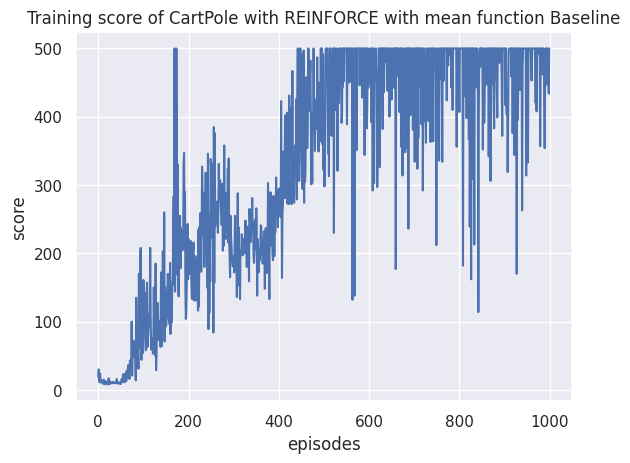

In [ ]:
draw('mean function Baseline')

### Прогоним выбранную политику

In [ ]:
test(env, policy_network_m, nums=200)

<ipython-input-9-cd3e5d2df9f9>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(nums)):


  0%|          | 0/200 [00:00<?, ?it/s]

455.35

Получили результат со средней наградой 455. Уберя нормализацию, результат бы ухудшился.

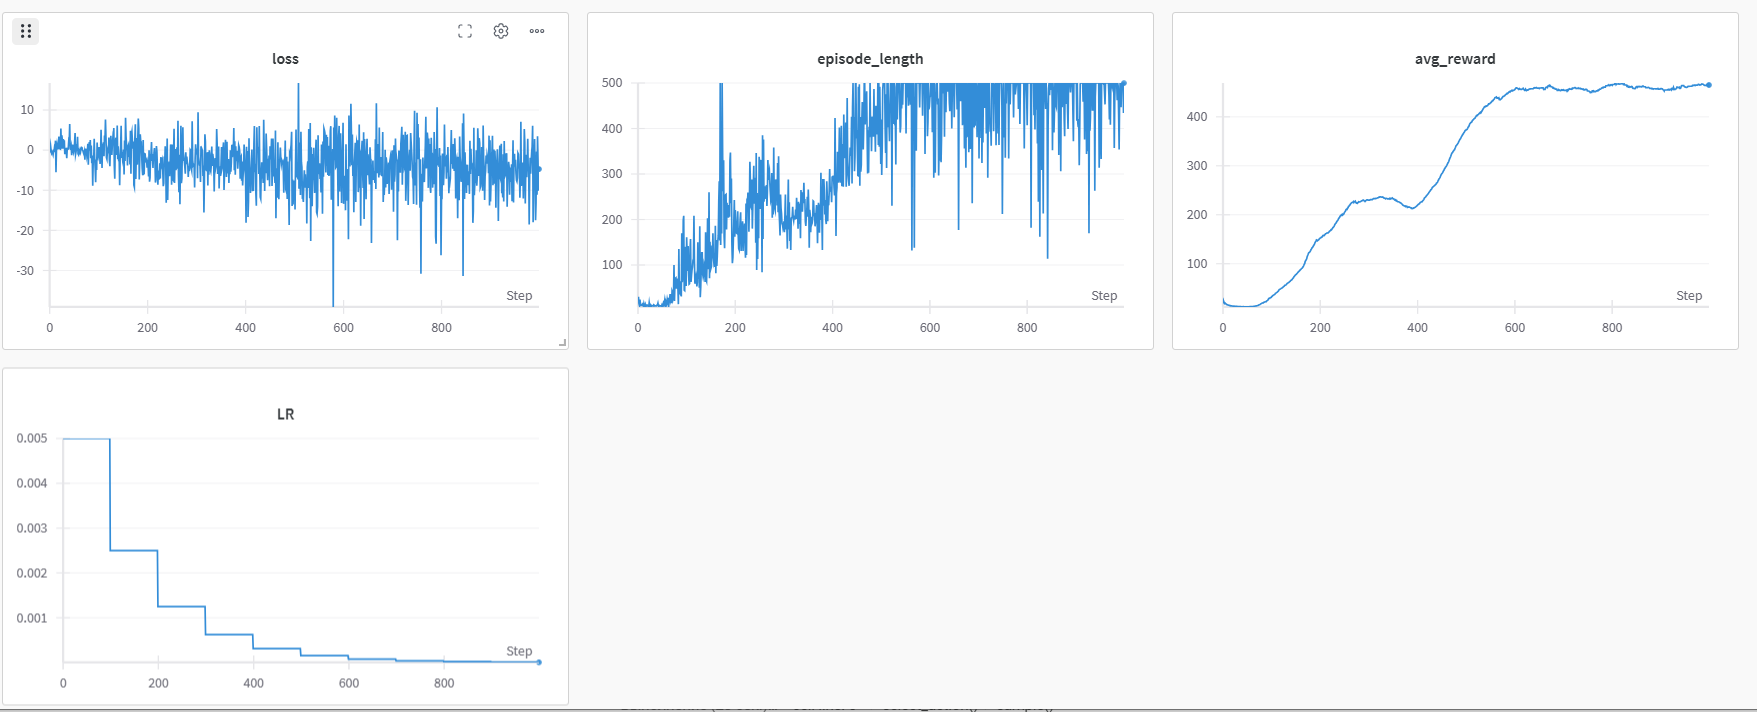

## Baseline как V - function

Сделаем обертку для Value функции

In [ ]:
class StateValueNetwork(nn.Module):
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()

        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        state_value = self.output_layer(x)

        return state_value

In [ ]:
def train_value(G, state_vals, optimizer):
    val_loss = F.mse_loss(state_vals, G)
    optimizer.zero_grad()
    val_loss.backward()
    optimizer.step()
    return val_loss.item()

In [ ]:
wandb.init(project="cartpole-baseline-v-function", reinit=True)
env = gym.make('CartPole-v1')
policy_network_vf = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
stateval_network = StateValueNetwork(env.observation_space.shape[0]).to(DEVICE)
policy_optimizer = optim.Adam(policy_network_vf.parameters(), lr=5e-3) # поменять
scheduler = StepLR(policy_optimizer, step_size=100, gamma=0.5)
stateval_optimizer = optim.Adam(stateval_network.parameters(), lr=5e-3) # поменять

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
scores = []
recent_scores = deque(maxlen=100)

for episode in tqdm_notebook(range(NUM_EPISODES)):

    state = env.reset()
    trajectory = []
    score = 0

    for step in range(MAX_STEPS):
        action, lp = select_action(policy_network_vf, state)
        new_state, reward, done, _ = env.step(action)
        score += reward
        trajectory.append([state, action, reward, lp])
        if done:
            break
        state = new_state
    scores.append(score)
    recent_scores.append(score)
    if len(recent_scores) == 100:
        average = sum(recent_scores)/len(recent_scores)
        if average >= SOLVED_SCORE:
            print(average)
            break
    states = [step[0] for step in trajectory]
    actions = [step[1] for step in trajectory]
    rewards = [step[2] for step in trajectory]
    lps = [step[3] for step in trajectory]
    G = process_rewards(rewards)
    state_vals = []
    for state in states:
        state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        state_vals.append(stateval_network(state))

    state_vals = torch.stack(state_vals).squeeze()

    v_func_loss = train_value(G, state_vals, stateval_optimizer)

    deltas = G - state_vals.detach()
    if len(G) > 1:
      deltas = (deltas - deltas.mean()) / (deltas.std() + 1e-8)
    deltas = torch.tensor(deltas).to(DEVICE)

    loss = train_policy(deltas, lps, policy_optimizer, scheduler)
    wandb.log({
        "loss": loss,
        "episode_length": len(trajectory),
        "avg_reward": np.mean(recent_scores),
        "LR": scheduler.get_last_lr()[0]
    })


env.close()
wandb.finish()

<ipython-input-19-e7c8cbe1a4b8>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for episode in tqdm_notebook(range(NUM_EPISODES)):


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-19-e7c8cbe1a4b8>:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deltas = torch.tensor(deltas).to(DEVICE)


LR,██▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,▁▁▁▁▁▃▃▄▄▄▄▄▄▅▆▆▆▇▇█████████████████████
episode_length,▁▂▁▅▄▂▂▂▇▄██▆██████▇███▂██▆████▅▇█▅████▄
loss,▅▄▁▄▅▇█▄▆▃▂▅▅▁▃▅▆▄▆▅▃▄▅▄▆▇▁▅▁▃▄▃▅█▂▃▅█▃█
LR,0.0
avg_reward,490.36
episode_length,500
loss,-10.30342


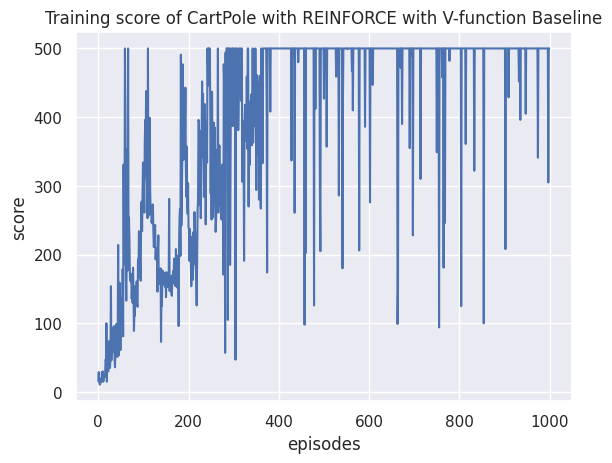

<ipython-input-9-cd3e5d2df9f9>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(nums)):


  0%|          | 0/200 [00:00<?, ?it/s]

486.8

In [ ]:
draw('V-function Baseline')
test(env, policy_network_vf, nums=200)

Обучилась тоже неплохо, получая высокую награду.

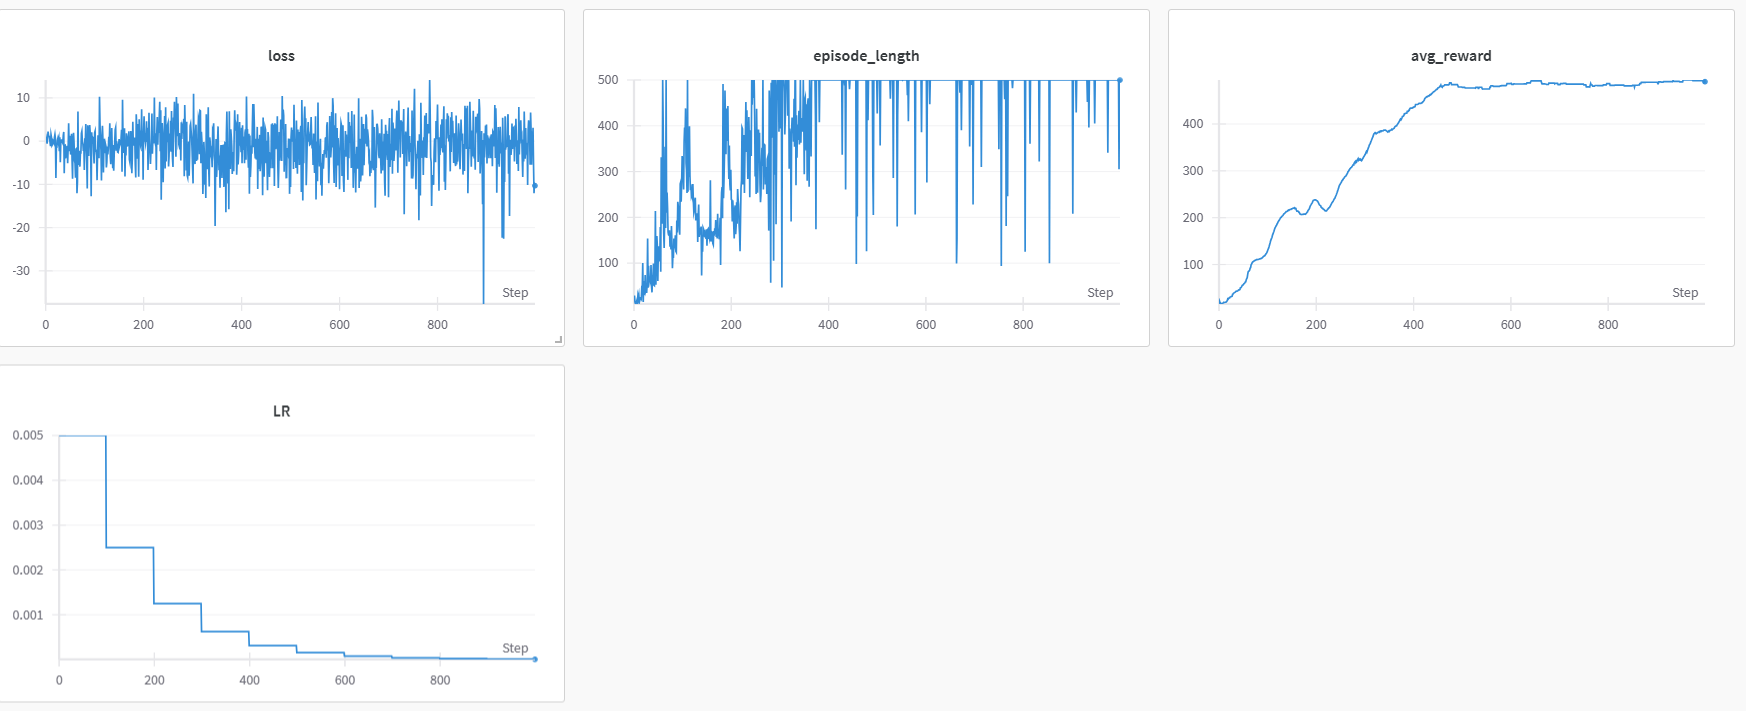

## RLOO Baseline

In [ ]:
env = gym.make('CartPole-v1')
wandb.init(project="cartpole-baseline-RLOO", reinit=True)
policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
policy_optimizer = optim.Adam(policy_network.parameters(), lr=5e-3)
scheduler = StepLR(policy_optimizer, step_size=150, gamma=0.5)


In [ ]:
scores = []
recent_scores = deque(maxlen=100)
for episode in tqdm_notebook(range(NUM_EPISODES)):
    state = env.reset()
    trajectory = []
    score = 0
    for step in range(MAX_STEPS):
        action, lp = select_action(policy_network, state)
        new_state, reward, done, _ = env.step(action)
        score += reward
        trajectory.append([state, action, reward, lp])

        if done:
            break

        state = new_state
    scores.append(score)
    recent_scores.append(score)
    if len(recent_scores) == 100:
        average = sum(recent_scores) / len(recent_scores)
        if average >= SOLVED_SCORE:
            print("Solved with average score:", average)
            break
    states = [step[0] for step in trajectory]
    actions = [step[1] for step in trajectory]
    rewards = [step[2] for step in trajectory]
    lps = [step[3] for step in trajectory]
    G = process_rewards(rewards)

    if G.shape[0] > 1:
        total_G = torch.sum(G)
        rloo_baselines = (total_G - G) / (G.shape[0] - 1)
    else:
        rloo_baselines = torch.zeros_like(G)
    advantages = G - rloo_baselines
    if len(G) > 1:
      advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)


    loss = train_policy(advantages, lps, policy_optimizer, scheduler)
    wandb.log({
        "loss": loss,
        "episode_length": len(trajectory),
        "avg_reward": np.mean(recent_scores),
        "LR": scheduler.get_last_lr()[0]
    })


env.close()
wandb.finish()

<ipython-input-22-7304cca90644>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for episode in tqdm_notebook(range(NUM_EPISODES)):


  0%|          | 0/1000 [00:00<?, ?it/s]

Solved with average score: 497.07


LR,███████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁
avg_reward,▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
episode_length,▁▁▂▁▁▁▁▂▁▂▂▂▂▄▃▁▂▂▄▅▇▃▃▃▃███▇███████████
loss,▄▄▄▄▄▄▄▄▄▅▄▄▄▄▄▃▃▅▅▅▆▃▄▂▁▄▆▃▅▄▅▁▃▇▇▅▃▄█▃
LR,0.00125
avg_reward,495.93
episode_length,500
loss,-1.98891


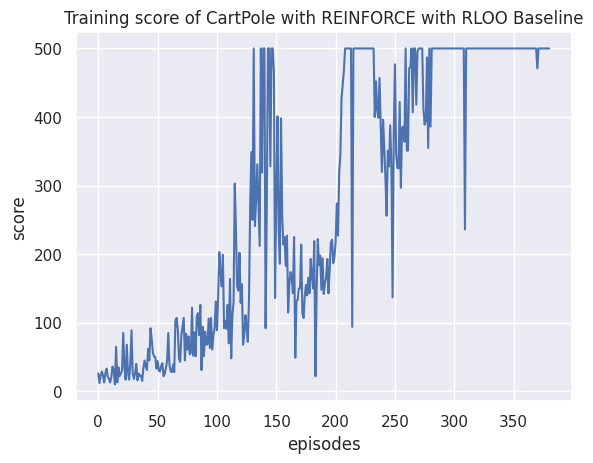

<ipython-input-9-cd3e5d2df9f9>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(nums)):


  0%|          | 0/200 [00:00<?, ?it/s]

496.265

In [ ]:
draw('RLOO Baseline')
test(env, policy_network, nums = 200)

Получили пока что высшую награду, при этом, первую удовлетворяющую критериям остановки модель. Добавим энтропию к лоссу.

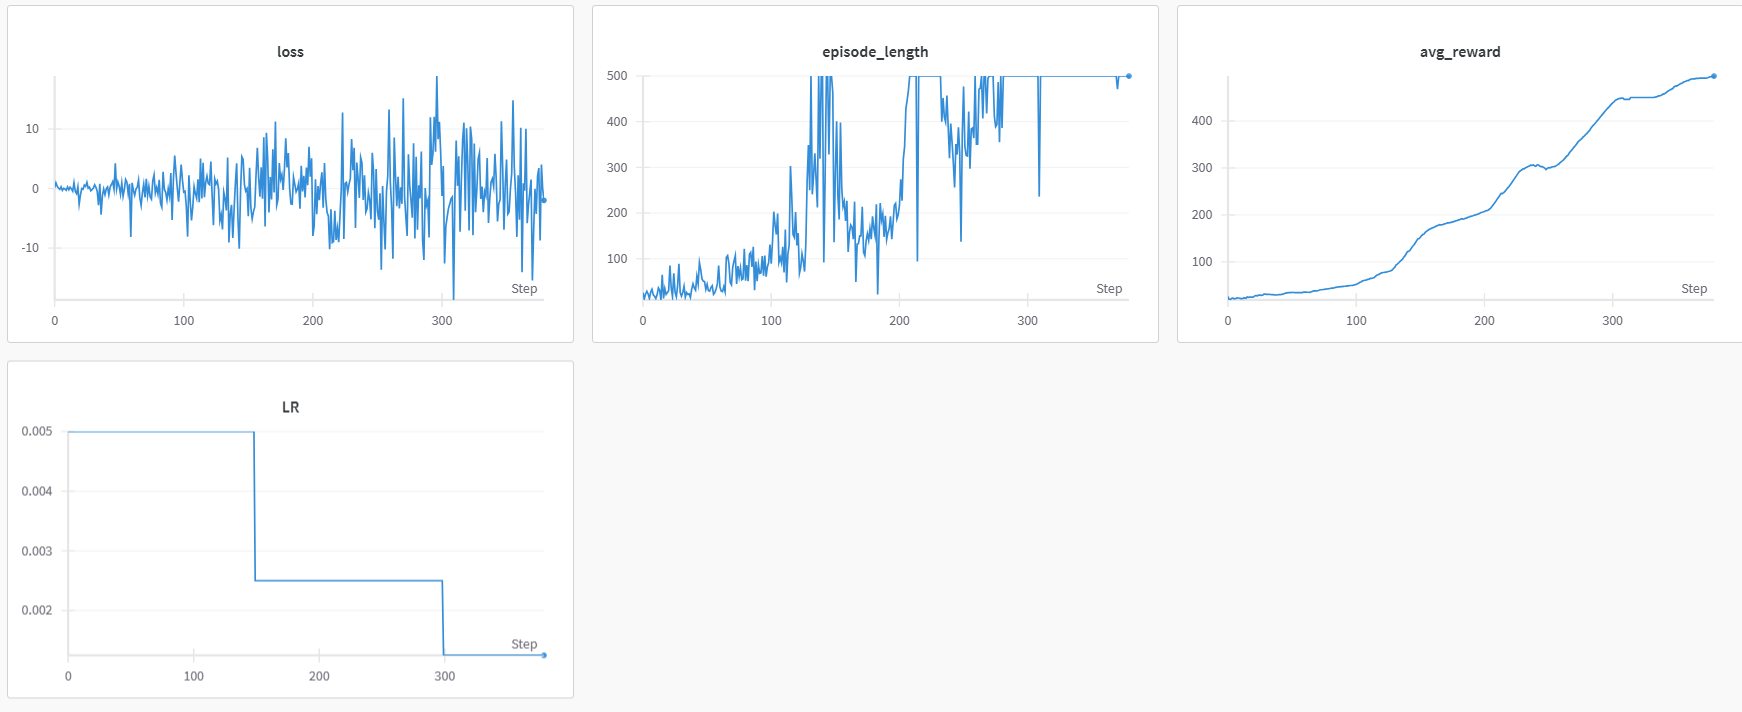

## Модифицируем расчет лосса

Добавим расчет энтропии

In [ ]:
def select_action(network, state):
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    action_probs = network(state)
    m = Categorical(action_probs)
    action = m.sample()
    return action.item(), m.log_prob(action), m.entropy()

In [ ]:
def train_policy(deltas, log_probs, entropies, optimizer, entropy_coef, scheduler):
    policy_loss = []
    for d, lp, ent in zip(deltas, log_probs, entropies):
        policy_loss.append(-d * lp + entropy_coef * ent)

    optimizer.zero_grad()
    loss = sum(policy_loss)
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()


In [ ]:
def test(env, policy_network, nums=100):
  done = False
  state = env.reset()
  scores = []

  for _ in tqdm_notebook(range(nums)):
      state = env.reset()
      done = False
      score = 0
      while not done:
          action, lp, _ = select_action(policy_network, state)
          new_state, reward, done, info = env.step(action)
          score += reward
          state = new_state
      scores.append(score)
  return np.array(scores).mean()

### Baseline - Mean function

In [ ]:
env = gym.make('CartPole-v1')
wandb.init(project="cartpole-baseline-mean-entropy", reinit=True)
policy_network_mean = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
policy_optimizer = optim.Adam(policy_network_mean.parameters(), lr=5e-3)
scheduler = StepLR(policy_optimizer, step_size=250, gamma=0.5)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pssskir (pssskir-central-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
scores = []
recent_scores = deque(maxlen=100)
initial_entropy_coef = 0.05
for episode in tqdm_notebook(range(NUM_EPISODES)):
    state = env.reset()
    trajectory = []
    score = 0
    for step in range(MAX_STEPS):
        action, lp, ent = select_action(policy_network_mean, state)
        new_state, reward, done, _ = env.step(action)
        score += reward
        trajectory.append([state, action, reward, lp, ent])
        if done:
            break
        state = new_state
    scores.append(score)
    recent_scores.append(score)

    if len(recent_scores) == 100:
        average = sum(recent_scores)/len(recent_scores)
        if average >= SOLVED_SCORE:
            print(average)
            break

    states = [step[0] for step in trajectory]
    actions = [step[1] for step in trajectory]
    rewards = [step[2] for step in trajectory]
    lps = [step[3] for step in trajectory]
    entropies = [step[4] for step in trajectory]
    G = process_rewards(rewards)
    average_reward = torch.mean(G)
    deltas = G - average_reward
    if len(G) > 1:
      deltas = (deltas - deltas.mean()) / (deltas.std() + 1e-8)
    deltas = torch.tensor(deltas).to(DEVICE)

    current_entropy_coef = initial_entropy_coef * (1 - episode / NUM_EPISODES)
    loss = train_policy(deltas, lps, entropies, policy_optimizer, current_entropy_coef, scheduler)
    wandb.log({
        "loss": loss,
        "episode_length": len(trajectory),
        "avg_reward": np.mean(recent_scores),
        "LR": scheduler.get_last_lr()[0],
        "entropy": torch.stack(entropies).mean().item(),
        'entropy_coef': current_entropy_coef
    })


env.close()
wandb.finish()

<ipython-input-15-7331f08ba119>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for episode in tqdm_notebook(range(NUM_EPISODES)):


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-15-7331f08ba119>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deltas = torch.tensor(deltas).to(DEVICE)


497.47


LR,██████████████▄▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
avg_reward,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▆▇▇▇▆▆▃▃▃▃▃▄▄▄▅█
entropy,█▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▂▂▁▁▁▁▁▁
entropy_coef,█████▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
episode_length,▁▁▁▂▁▁▂▂▃▂▃▃▃▃▃▃▅▅▆▄▄▃▃▃▃▃▃▃▃▃▄▄▄▃▄█████
loss,▅▅▄▆▆▃▅▇▄▆▅▅▃▅▅▅▅▅▃▄▁▃▃▃▃▃▂▃▂▁▅▃▇▄▄▆█▅▇▄
LR,0.00063
avg_reward,496.64
entropy,0.26516
entropy_coef,0.00155
episode_length,500


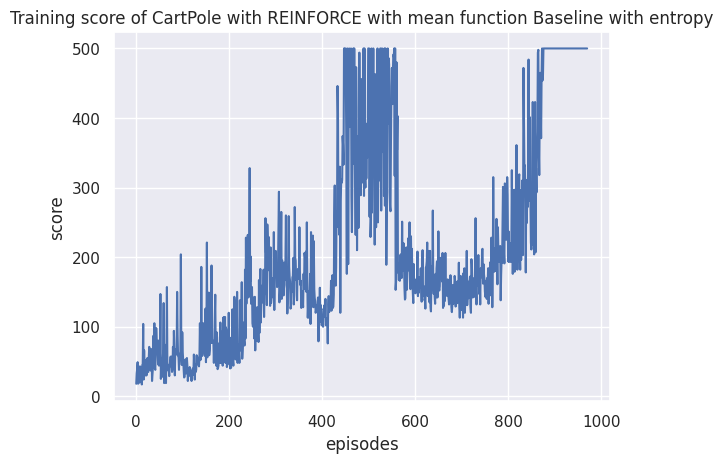

<ipython-input-13-65dbb56b448f>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(nums)):


  0%|          | 0/200 [00:00<?, ?it/s]

499.0

In [ ]:
draw('mean function Baseline with entropy')
test(env, policy_network_mean, nums=200)

Улучшили итоговый результат

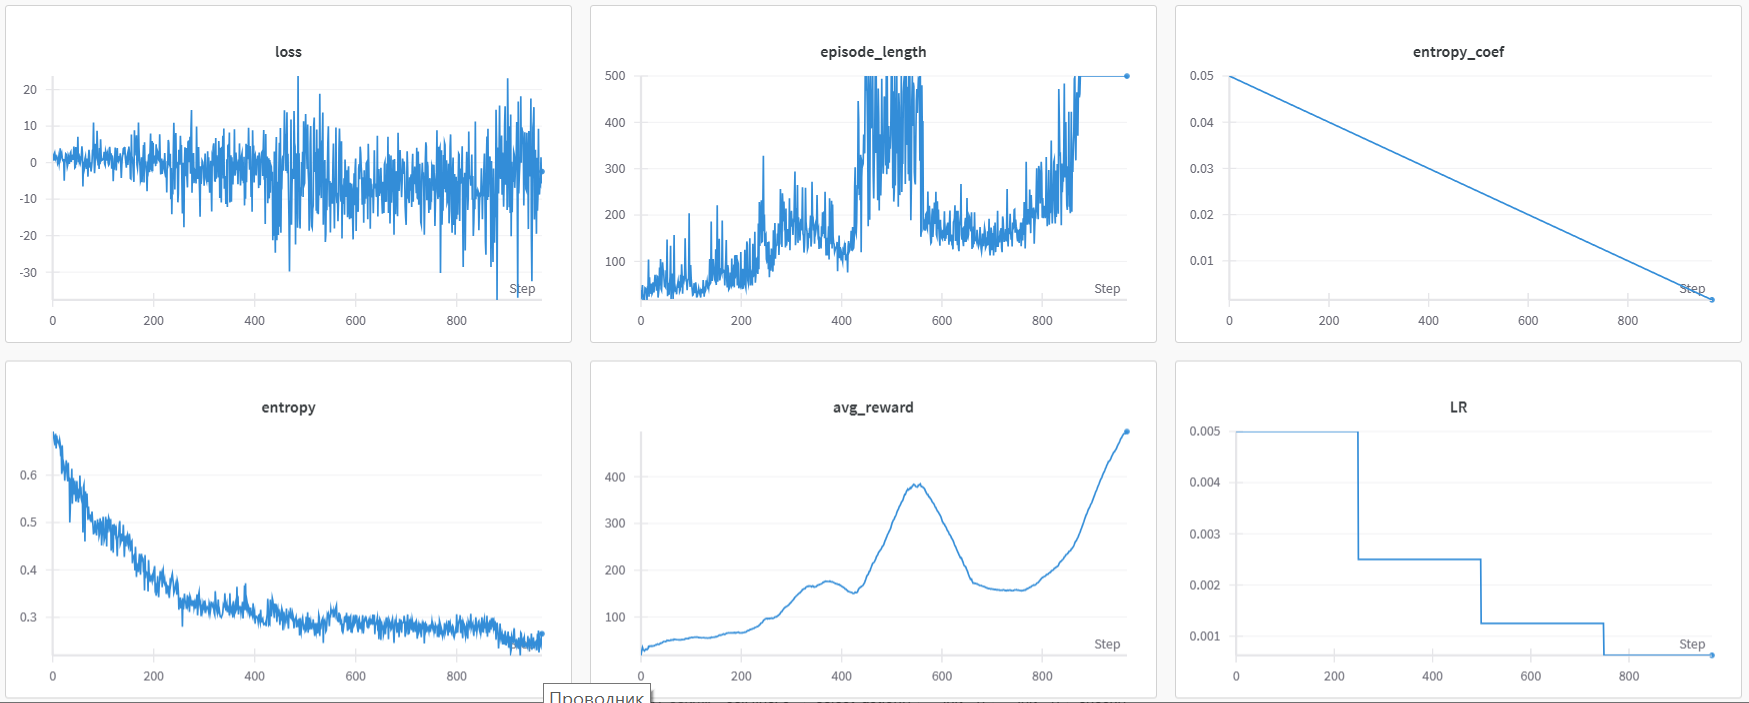

## Baseline - V_function

In [ ]:
wandb.init(project="cartpole-baseline-v-function-entropy", reinit=True)
env = gym.make('CartPole-v1')
policy_network_v = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
stateval_network = StateValueNetwork(env.observation_space.shape[0]).to(DEVICE)
policy_optimizer = optim.Adam(policy_network_v.parameters(), lr=5e-3) # поменять
scheduler = StepLR(policy_optimizer, step_size=100, gamma=0.5)
stateval_optimizer = optim.Adam(stateval_network.parameters(), lr=5e-3) # поменять

In [ ]:
scores = []

recent_scores = deque(maxlen=100)
initial_entropy_coef = 0.05
for episode in tqdm_notebook(range(NUM_EPISODES)):
    state = env.reset()
    trajectory = []
    score = 0
    for step in range(MAX_STEPS):
        action, lp, ent = select_action(policy_network_v, state)
        new_state, reward, done, _ = env.step(action)
        score += reward
        trajectory.append([state, action, reward, lp, ent])
        if done:
            break
        state = new_state
    scores.append(score)
    recent_scores.append(score)
    if len(recent_scores) == 100:
        average = sum(recent_scores)/len(recent_scores)
        if average >= SOLVED_SCORE:
            print(average)
            break

    states = [step[0] for step in trajectory]
    actions = [step[1] for step in trajectory]
    rewards = [step[2] for step in trajectory]
    lps = [step[3] for step in trajectory]
    entropies = [step[4] for step in trajectory]

    G = process_rewards(rewards)
    state_vals = []
    for state in states:
        state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        state_vals.append(stateval_network(state))

    state_vals = torch.stack(state_vals).squeeze()

    v_func_loss = train_value(G, state_vals, stateval_optimizer)
    deltas = G - state_vals.detach()
    if len(G) > 1:
      deltas = (deltas - deltas.mean()) / (deltas.std() + 1e-8)
    deltas = torch.tensor(deltas).to(DEVICE)

    current_entropy_coef = initial_entropy_coef * (1 - episode / NUM_EPISODES)
    loss = train_policy(deltas, lps, entropies, policy_optimizer, current_entropy_coef, scheduler)
    wandb.log({
        "loss": loss,
        "episode_length": len(trajectory),
        "avg_reward": np.mean(recent_scores),
        "LR": scheduler.get_last_lr()[0],
        "entropy": torch.stack(entropies).mean().item(),
        'entropy_coef': current_entropy_coef
    })


env.close()
wandb.finish()

<ipython-input-24-a98c452914dd>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for episode in tqdm_notebook(range(NUM_EPISODES)):


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-24-a98c452914dd>:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deltas = torch.tensor(deltas).to(DEVICE)


497.54


LR,██████████████▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▁▁▁▁
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▅▅▆▆▇▇▇▇▇███████
entropy,▇▆▆▅██▆▇▇▇▆▅▅▅▆▄▄▄▃▄▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
entropy_coef,█████▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁
episode_length,▁▁▁▁▁▂▂▂▅▂▃██▄█▄▅▆▅▅▅███████████████████
loss,▃▄▃▃▃▃▃▃▃▄▃▃▃▅▅▄▆▇▅▄▃▃▂▄▃▂▆▂▄▆█▄▄▆▇▁▅▃▃▆
LR,0.00063
avg_reward,495.41
entropy,0.43306
entropy_coef,0.0339
episode_length,500


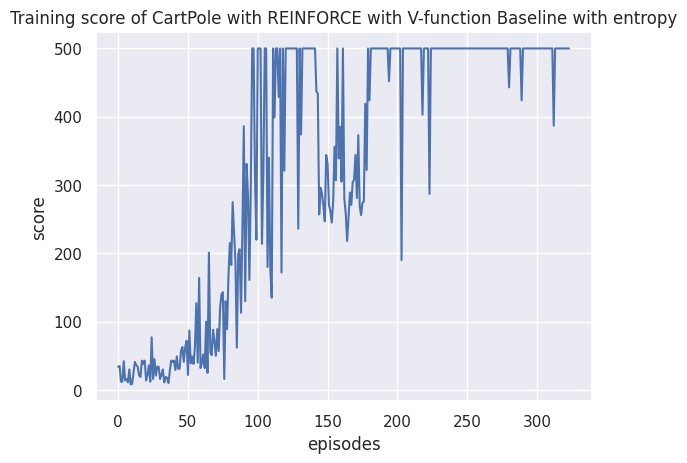

<ipython-input-13-65dbb56b448f>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(nums)):


  0%|          | 0/200 [00:00<?, ?it/s]

498.215

In [ ]:
draw('V-function Baseline with entropy')
test(env, policy_network_v, nums=200)

Тоже хорошо обучилась.

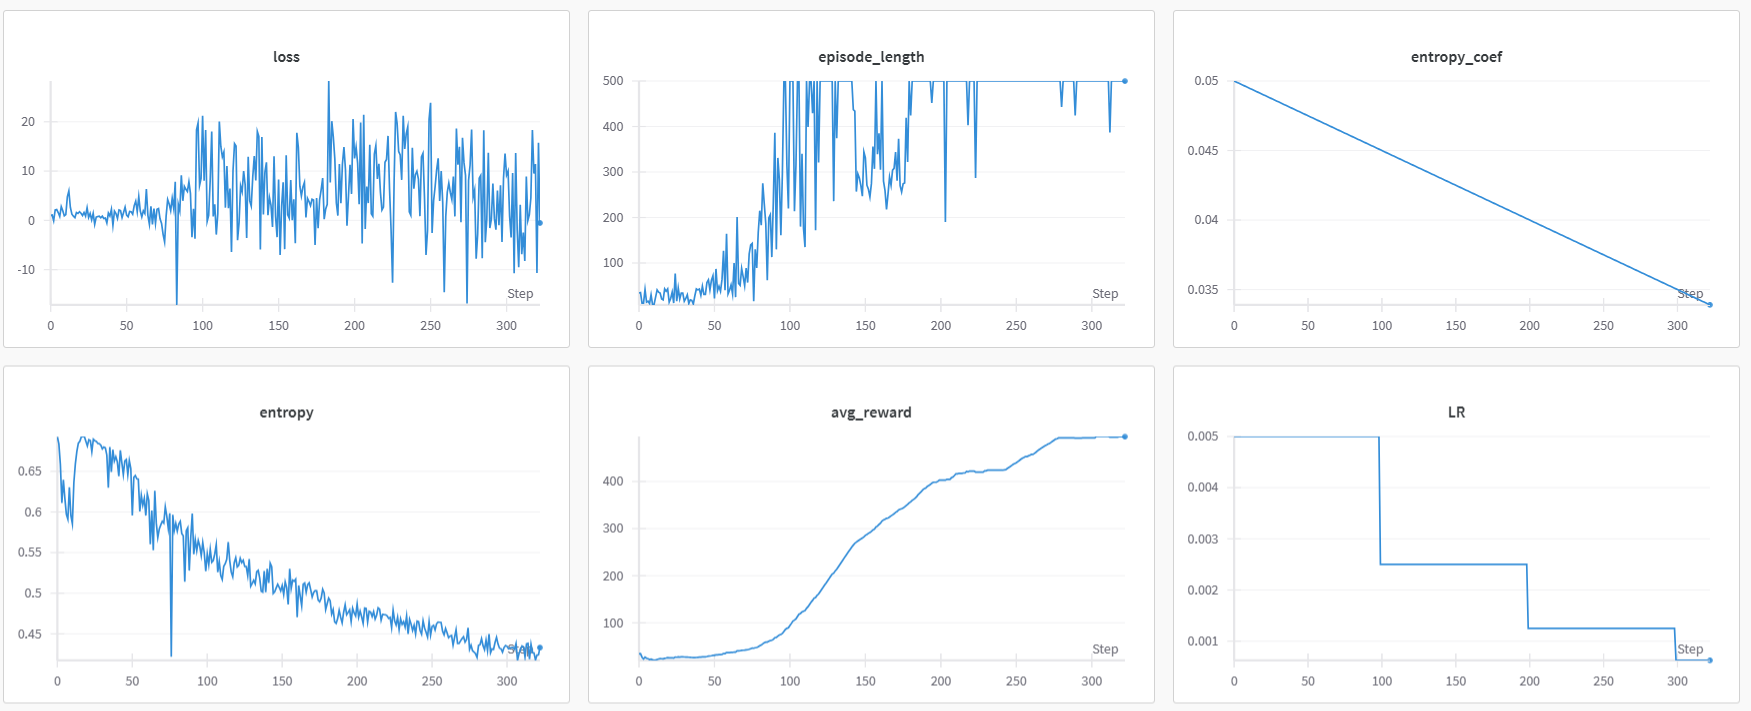

## Baseline - RLOO

In [ ]:
env = gym.make('CartPole-v1')
wandb.init(project="cartpole-baseline-RLOO-entropy", reinit=True)
policy_network_rloo = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
policy_optimizer = optim.Adam(policy_network_rloo.parameters(), lr=5e-3) # поменять
scheduler = StepLR(policy_optimizer, step_size=150, gamma=0.5)

In [ ]:
scores = []
recent_scores = deque(maxlen=100)
initial_entropy_coef = 0.05
for episode in tqdm_notebook(range(NUM_EPISODES)):
    state = env.reset()
    trajectory = []
    score = 0
    for step in range(MAX_STEPS):
        action, lp, ent = select_action(policy_network_rloo, state)
        new_state, reward, done, _ = env.step(action)
        score += reward
        trajectory.append([state, action, reward, lp, ent])

        if done:
            break

        state = new_state
    scores.append(score)
    recent_scores.append(score)
    if len(recent_scores) == 100:
        average = sum(recent_scores) / len(recent_scores)
        if average >= SOLVED_SCORE:
            print("Solved with average score:", average)
            break
    states = [step[0] for step in trajectory]
    actions = [step[1] for step in trajectory]
    rewards = [step[2] for step in trajectory]
    lps = [step[3] for step in trajectory]
    entropies = [step[4] for step in trajectory]
    G = process_rewards(rewards)

    if G.shape[0] > 1:
        total_G = torch.sum(G)
        rloo_baselines = (total_G - G) / (G.shape[0] - 1)
    else:
        rloo_baselines = torch.zeros_like(G)

    advantages = G - rloo_baselines
    if len(G) > 1:
      advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    current_entropy_coef = initial_entropy_coef * (1 - episode / NUM_EPISODES)
    loss = train_policy(advantages, lps, entropies, policy_optimizer, current_entropy_coef, scheduler)
    wandb.log({
        "loss": loss,
        "episode_length": len(trajectory),
        "avg_reward": np.mean(recent_scores),
        "LR": scheduler.get_last_lr()[0],
        "entropy": torch.stack(entropies).mean().item(),
        'entropy_coef': current_entropy_coef
    })


env.close()
wandb.finish()

<ipython-input-30-3c71fa7f8215>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for episode in tqdm_notebook(range(NUM_EPISODES)):


  0%|          | 0/1000 [00:00<?, ?it/s]

Solved with average score: 497.1


LR,██████████████████████▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁
avg_reward,▁▁▁▁▂▂▂▂▃▃▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇███████████████
entropy,▇███▇▇▆▆▆▆▆▅▅▅▆▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
entropy_coef,██▇▇▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
episode_length,▁▁▁▄▂▂▂▃▂▄▆▇██▇███▄▆▇▆████▄█████████████
loss,▄▄▄▅▃▄▄▅▅▃▅▅▇▃▄▄▄▅▄▆▄▃▆▅▇▆▄▁▄▅▃█▃▇▆▇▄▂▅▃
LR,0.00125
avg_reward,496.82
entropy,0.34644
entropy_coef,0.03195
episode_length,500


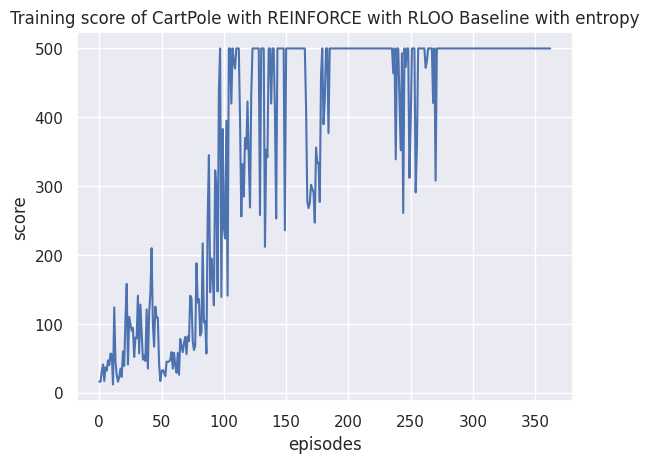

<ipython-input-13-65dbb56b448f>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(nums)):


  0%|          | 0/200 [00:00<?, ?it/s]

500.0

In [ ]:
draw('RLOO Baseline with entropy')
test(env, policy_network_rloo, nums = 200)

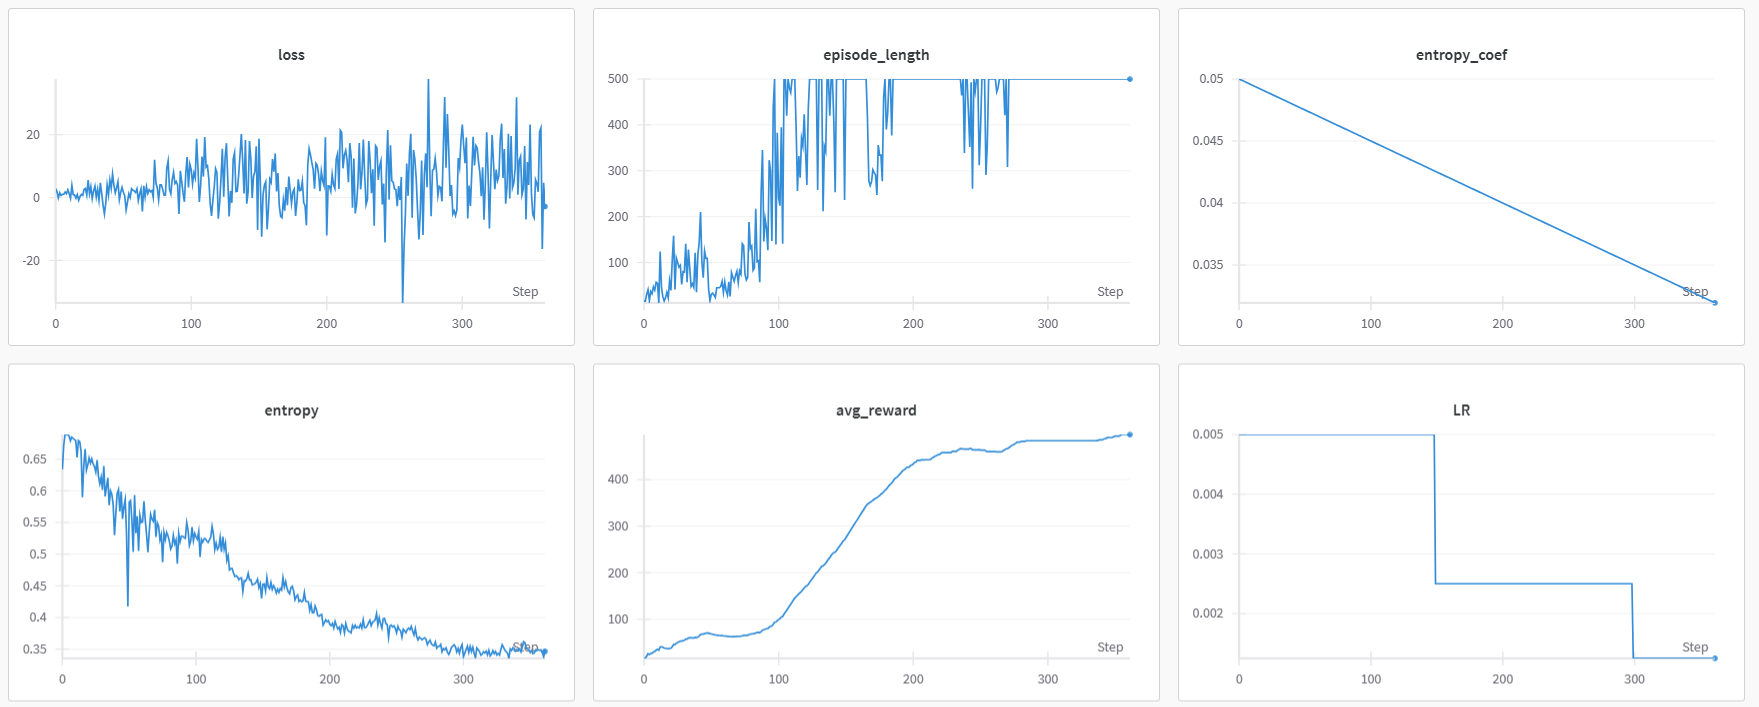

**Итоги**

Награды для моделей с бейзлайны, но без энтропии:

1) среднее - 455

2) v-function - 486

3) RLOO - 496

Регуляризация через энтропию:

1) среднее - 499

2) v-function - 498

3) RLOO - 500

**Выводы**:

1) RLOO Baseline выглядит наиболее выигрышным вариантом, как при наличии регуляционного слагаемого энтропии в лоссе, так и без него. Возьму за основу RLOO Baseline. Более того, RLOO еще и быстрее.

2) Результаты улучшились для всех экспериментов при использовании энтропии за счет того, что на начальных этапах агент экспериментирует в пространстве, выбирая неочевидные варианты.

3) Энтропия во всех экспериментах снижается по мере увеличения награды - политика становится более детерменированной.

4) Использование подхода с V-функцией более затратно по времени и ресурсам.

5) Нормализация позволяет  стабилизировать решение.



## Нагенерируем траекторий

In [ ]:
expert_policy = policy_network_rloo

In [ ]:
num_trajectories = 200
expert_trajectories = []
total_rewards = []

expert_policy.eval()

for _ in range(num_trajectories):
    state = env.reset()
    states, actions = [], []
    episode_reward = 0

    for _ in range(500):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            action_probs = expert_policy(state_tensor)
            action = torch.argmax(action_probs).item()

        next_state, reward, done, _ = env.step(action)

        states.append(state)
        actions.append(action)
        episode_reward += reward
        state = next_state

        if done:
            break

    expert_trajectories.append((states, actions))
    total_rewards.append(episode_reward)

mean_reward = np.mean(total_rewards)
print(f"\nExpert's average reward: {mean_reward:.1f} ± {np.std(total_rewards):.1f}")


Expert's average reward: 500.0 ± 0.0


In [ ]:
def prepare_data(trajectories):
    """Конвертирует траектории в тензоры состояний и действий"""
    states, actions = [], []
    for trajectory in trajectories:
        states.extend(trajectory[0])
        actions.extend(trajectory[1])
    return (
        torch.FloatTensor(np.array(states)).to(DEVICE),
        torch.LongTensor(np.array(actions)).to(DEVICE)
    )

class BCModel(nn.Module):
    def __init__(self, input_dim=4, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim))

    def forward(self, x):
        return self.net(x)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

def train_bc(model, states, actions, env, epochs=10, batch_size=32, eval_every=10):
    dataset = TensorDataset(states.to(device), actions.to(device))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_states, batch_actions in loader:
            optimizer.zero_grad()
            logits = model(batch_states)
            loss = criterion(logits, batch_actions)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        wandb.log({
        "loss": epoch_loss/len(loader)
        })

        if (epoch + 1) % eval_every == 0:
            avg_reward = evaluate_bc(model, env, n_episodes=100)
            print(f"Validation after epoch {epoch+1} | Avg Reward: {avg_reward:.1f}")
            wandb.log({"val_reward": avg_reward})

    wandb.finish()
    return model

In [ ]:
def evaluate_bc(model, env, n_episodes=100):
    model.eval()
    total_rewards = []

    for _ in range(n_episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            with torch.no_grad():
                action_logits = model(torch.FloatTensor(state).unsqueeze(0).to(device))
                action = torch.argmax(action_logits).item()

            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            state = next_state

        total_rewards.append(episode_reward)

    return np.mean(total_rewards)

In [ ]:
states, actions = prepare_data(expert_trajectories)
wandb.init(project="cartpole-SFT", reinit=True)
model = BCModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
trained_model = train_bc(
        model,
        states,
        actions,
        env=gym.make("CartPole-v1"),
        epochs=5,
        eval_every=1
    )

env = gym.make("CartPole-v1")
mean_reward = evaluate_bc(trained_model, env)
print(f"Average reward: {mean_reward}")

Validation after epoch 1 | Avg Reward: 500.0
Validation after epoch 2 | Avg Reward: 500.0
Validation after epoch 3 | Avg Reward: 500.0
Validation after epoch 4 | Avg Reward: 500.0
Validation after epoch 5 | Avg Reward: 500.0


loss,█▄▃▂▁
val_reward,▁▁▁▁▁
loss,0.07245
val_reward,500


Average reward: 500.0


Решение сошлось к оптимальному. Добавим экспериментов.

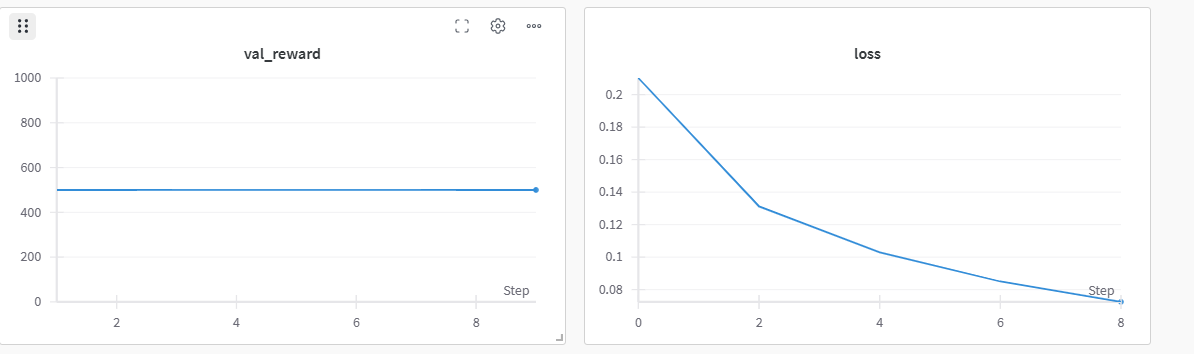

### Добавим шуму

In [ ]:
states, actions = prepare_data(expert_trajectories)
wandb.init(project="cartpole-SFT-noise", reinit=True)
noisy_model = BCModel()
noisy_model = noisy_model.to(device)
noisy_states = states + torch.randn_like(states) * 0.02
trained_model = train_bc(
        noisy_model,
        noisy_states,
        actions,
        env=gym.make("CartPole-v1"),
        epochs=40,
        eval_every=5
    )

env = gym.make("CartPole-v1")
mean_reward = evaluate_bc(trained_model, env)
print(f"Average reward: {mean_reward}")

Validation after epoch 5 | Avg Reward: 500.0
Validation after epoch 10 | Avg Reward: 500.0
Validation after epoch 15 | Avg Reward: 500.0
Validation after epoch 20 | Avg Reward: 500.0
Validation after epoch 25 | Avg Reward: 500.0
Validation after epoch 30 | Avg Reward: 500.0
Validation after epoch 35 | Avg Reward: 500.0
Validation after epoch 40 | Avg Reward: 500.0


loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_reward,▁▁▁▁▁▁▁▁
loss,0.2146
val_reward,500


Average reward: 500.0


2% шум не внес сильных правок, политика сразу сошлась.Добавим шуму 5%.

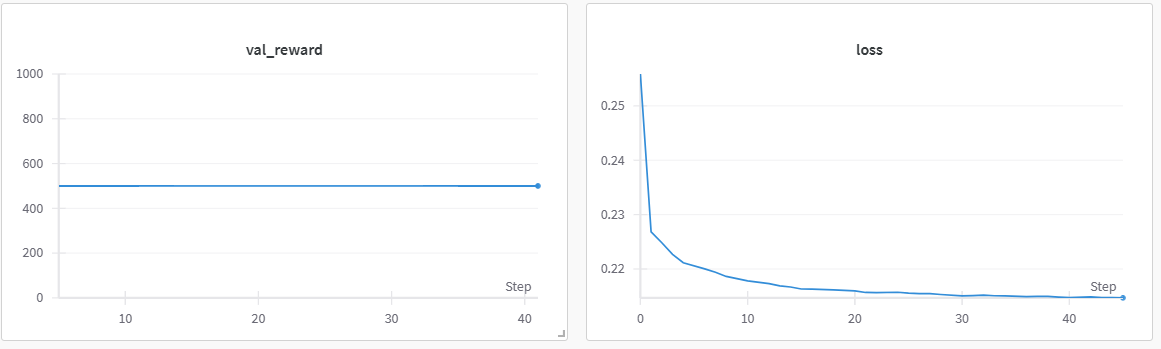

In [ ]:
states, actions = prepare_data(expert_trajectories)
wandb.init(project="cartpole-SFT-noise", reinit=True)
noisy_model = BCModel()
noisy_model = noisy_model.to(device)
noisy_states = states + torch.randn_like(states) * 0.05
trained_model = train_bc(
        noisy_model,
        noisy_states,
        actions,
        env=gym.make("CartPole-v1"),  # Передаем среду
        epochs=40,
        eval_every=5  # Валидация каждые 5 эпох
    )

env = gym.make("CartPole-v1")
mean_reward = evaluate_bc(trained_model, env)
print(f"Average reward: {mean_reward}")

Validation after epoch 5 | Avg Reward: 264.8
Validation after epoch 10 | Avg Reward: 389.1
Validation after epoch 15 | Avg Reward: 372.4
Validation after epoch 20 | Avg Reward: 401.9
Validation after epoch 25 | Avg Reward: 367.3
Validation after epoch 30 | Avg Reward: 341.8
Validation after epoch 35 | Avg Reward: 374.8
Validation after epoch 40 | Avg Reward: 351.4


loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_reward,▁▇▆█▆▅▇▅
loss,0.26921
val_reward,351.37


Average reward: 365.33


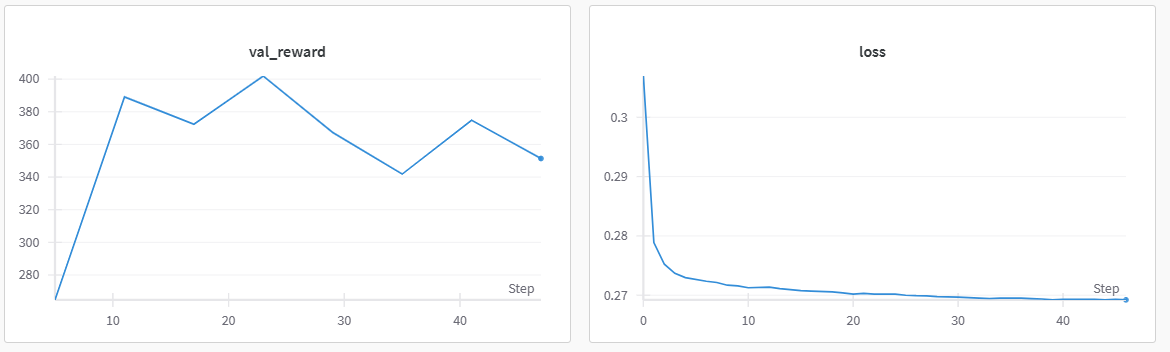

модель устойчива к шуму, но только до определенного уровня - не более 5%.

### Добавим эксперту ошибок

Добавим ошибку 8%

In [ ]:
num_trajectories = 200
false_expert_trajectories = []
total_rewards = []

expert_policy.eval()

for _ in range(num_trajectories):
    state = env.reset()
    states, actions = [], []
    episode_reward = 0

    for _ in range(500):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            action_probs = expert_policy(state_tensor)
            if np.random.rand() < 0.08:
              action = 1 - torch.argmax(action_probs).item()
            else:
              action = torch.argmax(action_probs).item()

        next_state, reward, done, _ = env.step(action)

        states.append(state)
        actions.append(action)
        episode_reward += reward
        state = next_state

        if done:
            break

    false_expert_trajectories.append((states, actions))
    total_rewards.append(episode_reward)

mean_reward = np.mean(total_rewards)
print(f"\nExpert's average reward: {mean_reward:.1f} ± {np.std(total_rewards):.1f}")


Expert's average reward: 488.3 ± 56.6


In [ ]:
states, actions = prepare_data(false_expert_trajectories)
wandb.init(project="cartpole-SFT-false8", reinit=True)
false_model = BCModel()
false_model = false_model.to(device)
trained_model = train_bc(
        false_model,
        states,
        actions,
        env=gym.make("CartPole-v1"),
        epochs=10,
        eval_every=1
    )

env = gym.make("CartPole-v1")
mean_reward = evaluate_bc(trained_model, env)
print(f"Average reward: {mean_reward}")

Validation after epoch 1 | Avg Reward: 500.0
Validation after epoch 2 | Avg Reward: 500.0
Validation after epoch 3 | Avg Reward: 500.0
Validation after epoch 4 | Avg Reward: 500.0
Validation after epoch 5 | Avg Reward: 500.0
Validation after epoch 6 | Avg Reward: 500.0
Validation after epoch 7 | Avg Reward: 500.0
Validation after epoch 8 | Avg Reward: 500.0
Validation after epoch 9 | Avg Reward: 500.0
Validation after epoch 10 | Avg Reward: 500.0


loss,█▅▃▂▂▂▁▁▁▁
val_reward,▁▁▁▁▁▁▁▁▁▁
loss,0.30448
val_reward,500


Average reward: 500.0


8% ошибка не дала сильного отклонения. Предполагаю, что из-за того, что траекторий достаточно много, задачка достаточно низкоразмерная (простая), поэтому даже ошибка может привести к состоянию, которое уже обрабатывается правильно и не приводит к падению.

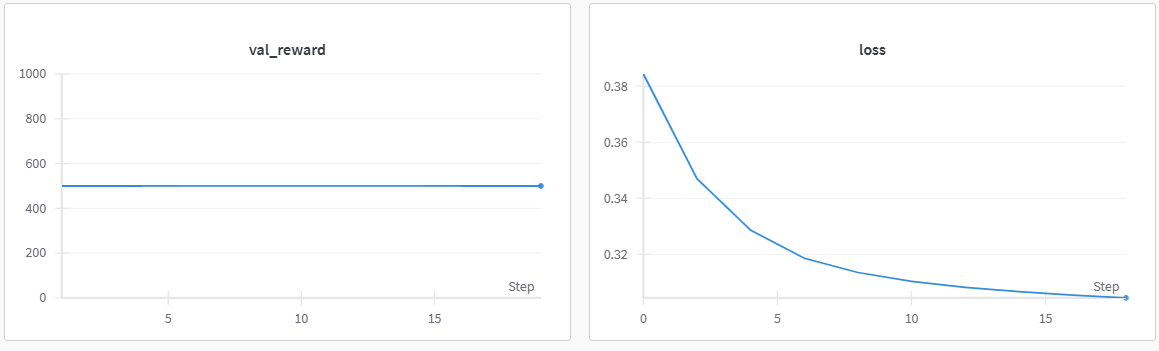

### Добавим ошибку 20%

In [ ]:
num_trajectories = 200
false_expert_trajectories = []
total_rewards = []

expert_policy.eval()

for _ in range(num_trajectories):
    state = env.reset()
    states, actions = [], []
    episode_reward = 0

    for _ in range(500):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            action_probs = expert_policy(state_tensor)
            if np.random.rand() < 0.2:
              action = 1 - torch.argmax(action_probs).item()
            else:
              action = torch.argmax(action_probs).item()

        next_state, reward, done, _ = env.step(action)
        states.append(state)
        actions.append(action)
        episode_reward += reward
        state = next_state

        if done:
            break

    false_expert_trajectories.append((states, actions))
    total_rewards.append(episode_reward)

mean_reward = np.mean(total_rewards)
print(f"\nExpert's average reward: {mean_reward:.1f} ± {np.std(total_rewards):.1f}")


Expert's average reward: 204.6 ± 119.4


In [ ]:
states, actions = prepare_data(false_expert_trajectories)
wandb.init(project="cartpole-SFT-false20", reinit=True)
false_model = BCModel()
false_model = false_model.to(device)
trained_model = train_bc(
        false_model,
        states,
        actions,
        env=gym.make("CartPole-v1"),
        epochs=20,
        eval_every=1
    )

env = gym.make("CartPole-v1")
mean_reward = evaluate_bc(trained_model, env)
print(f"Average reward: {mean_reward}")

Validation after epoch 1 | Avg Reward: 500.0
Validation after epoch 2 | Avg Reward: 500.0
Validation after epoch 3 | Avg Reward: 500.0
Validation after epoch 4 | Avg Reward: 500.0
Validation after epoch 5 | Avg Reward: 500.0
Validation after epoch 6 | Avg Reward: 500.0
Validation after epoch 7 | Avg Reward: 500.0
Validation after epoch 8 | Avg Reward: 500.0
Validation after epoch 9 | Avg Reward: 500.0
Validation after epoch 10 | Avg Reward: 500.0
Validation after epoch 11 | Avg Reward: 500.0
Validation after epoch 12 | Avg Reward: 500.0
Validation after epoch 13 | Avg Reward: 500.0
Validation after epoch 14 | Avg Reward: 500.0
Validation after epoch 15 | Avg Reward: 500.0
Validation after epoch 16 | Avg Reward: 500.0
Validation after epoch 17 | Avg Reward: 500.0
Validation after epoch 18 | Avg Reward: 500.0
Validation after epoch 19 | Avg Reward: 500.0
Validation after epoch 20 | Avg Reward: 500.0


loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.51266
val_reward,500


Average reward: 500.0


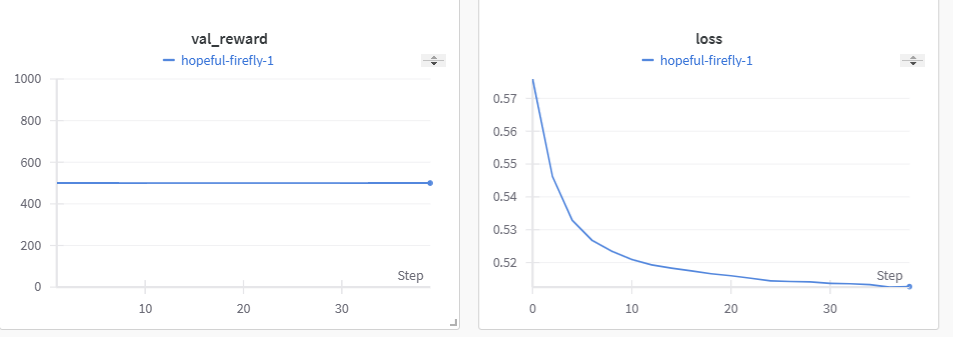

### Уменьшим число траекторий

In [ ]:
num_trajectories = 10
false_expert_trajectories = []
total_rewards = []

expert_policy.eval()

for _ in range(num_trajectories):
    state = env.reset()
    states, actions = [], []
    episode_reward = 0
    for _ in range(500):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            action_probs = expert_policy(state_tensor)
            if np.random.rand() < 0.2:
              action = 1 - torch.argmax(action_probs).item()
            else:
              action = torch.argmax(action_probs).item()

        next_state, reward, done, _ = env.step(action)

        states.append(state)
        actions.append(action)
        episode_reward += reward
        state = next_state

        if done:
            break

    false_expert_trajectories.append((states, actions))
    total_rewards.append(episode_reward)

mean_reward = np.mean(total_rewards)
print(f"\nExpert's average reward: {mean_reward:.1f} ± {np.std(total_rewards):.1f}")


Expert's average reward: 177.2 ± 128.2


In [ ]:
states, actions = prepare_data(false_expert_trajectories)
wandb.init(project="cartpole-SFT-false20", reinit=True)
false_model = BCModel()
false_model = false_model.to(device)
trained_model = train_bc(
        false_model,
        states,
        actions,
        env=gym.make("CartPole-v1"),
        epochs=100,
        eval_every=5
    )

env = gym.make("CartPole-v1")
mean_reward = evaluate_bc(trained_model, env)
print(f"Average reward: {mean_reward}")

Validation after epoch 5 | Avg Reward: 500.0
Validation after epoch 10 | Avg Reward: 500.0
Validation after epoch 15 | Avg Reward: 500.0
Validation after epoch 20 | Avg Reward: 500.0
Validation after epoch 25 | Avg Reward: 500.0
Validation after epoch 30 | Avg Reward: 500.0
Validation after epoch 35 | Avg Reward: 500.0
Validation after epoch 40 | Avg Reward: 498.2
Validation after epoch 45 | Avg Reward: 496.2
Validation after epoch 50 | Avg Reward: 480.9
Validation after epoch 55 | Avg Reward: 487.1
Validation after epoch 60 | Avg Reward: 491.8
Validation after epoch 65 | Avg Reward: 485.2
Validation after epoch 70 | Avg Reward: 482.0
Validation after epoch 75 | Avg Reward: 469.5
Validation after epoch 80 | Avg Reward: 493.1
Validation after epoch 85 | Avg Reward: 479.0
Validation after epoch 90 | Avg Reward: 477.4
Validation after epoch 95 | Avg Reward: 487.1
Validation after epoch 100 | Avg Reward: 496.2


loss,█▇▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁
val_reward,████████▇▄▅▆▅▄▁▆▃▃▅▇
loss,0.51377
val_reward,496.2


Average reward: 491.63


При малом количестве траекторий модель по началу правильные траектории выбирает, как раз потому что ошибается с точки зрения соответствия начальным траекториям, затем затачивается больше на некорректные траектории и начинает больше ошибаться.

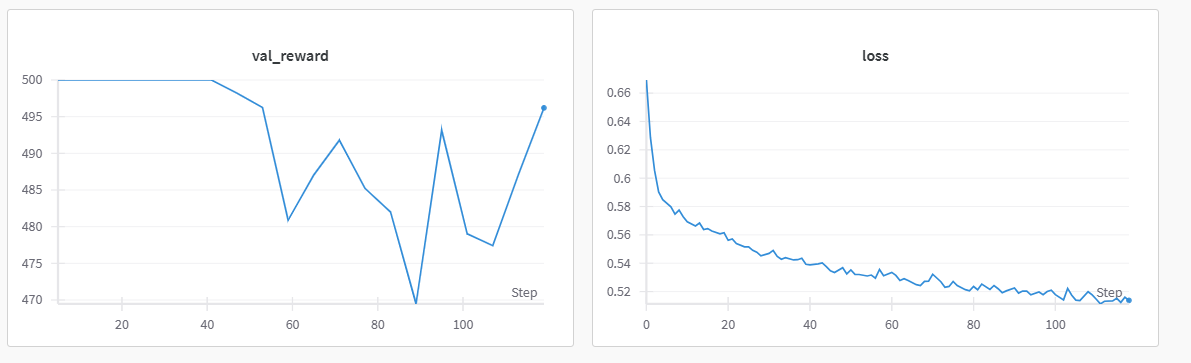

### Итоги по Behaviour cloning
1) Модель хорошо аппроксимирует хорошие правильные траектории. В некоторых случаях хорошо аппроксимирует и ошибки эксперта при достаточном числе экспертных траекторий. То есть применительно к LLM ошибку эксперта в разметке текста можно сгладить другими экспертами, что логично, ведь вместе у них уменьшается дисперсия.

2) Модель может быть неустойчива к шумным состояниям.